In [1]:
import GPyOpt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# enable memory growth on gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
# Datasets for hyperparameter tuning:
bcf_mordred_full_manual_polar = pd.read_csv('./data/targetset/bcf_mordred_full_manual_polar.csv', index_col=0)
bcf_mordred_full_classy_5 = pd.read_csv('./data/targetset/bcf_mordred_full_classy_5.csv', index_col=0)

In [3]:
# get numpy arrays for training
def get_data(dataframe):
    # use only what is reserved for base model
    bcf_general = dataframe[dataframe['Category'] == 0]

    # non-pfas used for training and testing set
    data = bcf_general.drop(columns=['Category'], axis=1)
    
    y = data.pop('logBCF').to_numpy()
    X = data.to_numpy()
    
    return X, y

In [4]:
# For my neural network I should be able to change number of layers, number of nodes in each layer
# As well as any other hyperparameters on the fly instead of having to write out Sequential each time.
class DNN(keras.Model):
    
    # can use __init__ to instantiate architecture, usually done this way
    # pass arguments array to init, and in init take out private variable initialization
    def __init__(self, n_layers=4, layer_size=200, batch_size=250, learning_rate=0.01, epochs=1000, seed=100):
        super().__init__()
        self.n_layers = n_layers
        self.layer_size = layer_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.seed = seed
        self.generate()
    
    def generate(self):
        self.pipeline = []
        
        for i, layer in enumerate(range(self.n_layers)):
            # batch normalization improves stability of model
            self.pipeline.append(layers.BatchNormalization())
            self.pipeline.append(layers.Dense(self.layer_size, activation='relu'))
            
        self.pipeline.append(layers.BatchNormalization())
        self.pipeline.append(layers.Dense(1, activation = 'linear'))
        
    def call(self, inputs):
        x = inputs
        for layer in self.pipeline:
            x = layer(x)
            
        return x
        
    def fit(self, x_train, y_train, **kwargs):
        tf.random.set_seed(self.seed)
        
        # build creates input layer based on training data shape
        super().build(input_shape=x_train.shape)
        super().compile(optimizer=keras.optimizers.Adam(self.learning_rate), loss='mean_squared_error', 
                        metrics=['mse', 'mae'])
        return super().fit(x_train, y_train, epochs=self.epochs, batch_size=self.batch_size, **kwargs)

In [5]:
# GyPyOpt bayesian optimization

default_domain = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 0.01)},
    {'name': 'n_layers', 'type': 'discrete', 'domain': range(3,12)},
    {'name': 'layer_size', 'type': 'discrete', 'domain': [32, 64, 128, 256, 512, 1024, 2048]},
    {'name': 'batch_size', 'type': 'discrete', 'domain': [32, 64, 128, 256, 512]},
]

class Best:
    def __init__(self, name):
        self.name = name
        self.info = {'score': np.inf, 'histories': None, 'metrics': None}  
    
    def summarize(self):
        print('Best model print out for ' + self.name + ':')
        print('--------------------------')
        print('Best MSE Score:', self.info['score'])
        print('Mean r2:', np.mean(self.info['metrics']['r2']))
        print('Mean mae:', np.mean(self.info['metrics']['mae']))
        print('Mean rmse:', np.mean(self.info['metrics']['rmse']))
        
    def plot_history(self, history, title=''):
        plt.plot(history.history['mse'], label='Train')
        plt.plot(history.history['val_mse'], label='Validation')

        plt.title('Loss v. Epoch' + title)
        plt.ylabel('MSE')
        plt.xlabel('Epoch')

        plt.legend(loc='upper right')
        plt.show()
        
    def plot_histories(self):
        if self.info['histories'] is not None:
            for fold, history in enumerate(self.info['histories']):
                self.plot_history(history, title=': Fold ' + str(fold))
        
#     def plot_history(self):
#         plt.plot(self.info['history'].history['mse'], label='Train')
#         plt.plot(self.info['history'].history['val_mse'], label='Validation')

#         plt.title('Loss v. Epoch')
#         plt.ylabel('MSE')
#         plt.xlabel('Epoch')

#         plt.legend(loc='upper right')
#         plt.show()
    
def feature_set(best, data):
    
    def search(x):
        X, y = data

        # mse more effective for optimization problems
        histories = []
        mse = []
        metrics = {'r2': [], 'mae': [], 'rmse': []}

        kf = KFold(n_splits=5, shuffle=True, random_state=1)

        for fold_no, (train, test) in enumerate(kf.split(X)):
            X_train, y_train = X[train], y[train]
            X_test, y_test = X[test], y[test]

            X_scaler = StandardScaler()
            X_scaler.fit(X_train)
            X_train_scaled = X_scaler.transform(X_train)
            X_test_scaled = X_scaler.transform(X_test)

            y_scaler = StandardScaler()
            y_scaler.fit(y_train.reshape(-1, 1))
            y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))
            y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

            model = DNN(learning_rate=float(x[:,0]), n_layers=int(x[:,1]), layer_size=int(x[:,2]), batch_size=int(x[:,3]))
            
            early_stopping = tf.keras.callbacks.EarlyStopping(patience=100,
                                                              monitor='val_loss',
                                                              mode='min',
                                                              restore_best_weights=True)

            history = model.fit(X_train_scaled, 
                                y_train_scaled,
                                callbacks=[early_stopping],
                                validation_data=(X_test_scaled, y_test_scaled),
                                verbose=0)
            histories.append(history)

            y_pred = y_scaler.inverse_transform(model.predict(X_test_scaled).reshape(-1,1))

            metrics['r2'].append(r2_score(y_test, y_pred.flatten()))
            metrics['mae'].append(mean_absolute_error(y_test, y_pred.flatten()))
            metrics['rmse'].append(mean_squared_error(y_test, y_pred.flatten(), squared=False))

            mse.append(mean_squared_error(y_test, y_pred.flatten()))

        score = np.mean(mse)

        # save model for final fold if score is best
        if score < best.info['score']:
            best.info['score'] = score
            best.info['histories'] = histories
            best.info['metrics'] = metrics

        return score
    
    return search

def run_bayesian(dataframe, domain, max_iter=40, tag=''):
    print('Processing...')
    best = Best('Bayesian Optimized Base DNN Model, ' + tag)
    search_function = feature_set(best, data=get_data(dataframe))
    optimizer = GPyOpt.methods.BayesianOptimization(f=search_function, 
                                                    domain=domain, 
                                                    model_type='GP', 
                                                    acquisition_type='EI',
                                                    acquisition_jitter = 0.05,
                                                    exact_feval = True,
                                                    maximize = False,
                                                    verbosity = True)
    print('Begin Optimizing...')
    optimizer.run_optimization(max_iter=max_iter)

    print('Optimization Completed.')
    # optimizer convergence
    optimizer.plot_convergence()
    
    # Retrieve best parameters and metrics from Bayesian optimization
    best_params = [(domain[i]['name'], optimum) for i, optimum in enumerate(optimizer.x_opt)]
    print('--------------------')
    print('Best Hyperparameters:')
    print(best_params)
    
    # get printout and model convergence information
    print('--------------------')
    best.summarize()
    best.plot_histories()

# Run Bayesian Optimization

Simply use `run_bayesian(dataframe, domain, max_iter=40, tag='')` function to get the bayesian optimized hyperparameters in a printout.

Processing...


2022-10-13 16:16:00.722947: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 16:16:03.789333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38184 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:b7:00.0, compute capability: 8.0
2022-10-13 16:16:09.501810: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Begin Optimizing...
Optimization Completed.


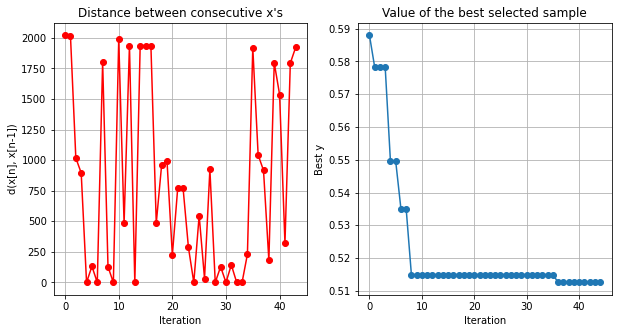

--------------------
Best Hyperparameters:
[('learning_rate', 0.0032828262686829435), ('n_layers', 3.0), ('layer_size', 2048.0), ('batch_size', 256.0)]
--------------------
Best model print out for Bayesian Optimized Base DNN Model: mfmp:
--------------------------
Best MSE Score: 0.5125479987977873
Mean r2: 0.7216853434972622
Mean mae: 0.5259863940904288
Mean rmse: 0.7106216403514096


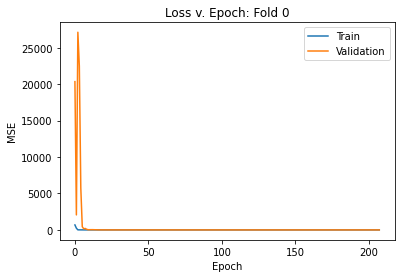

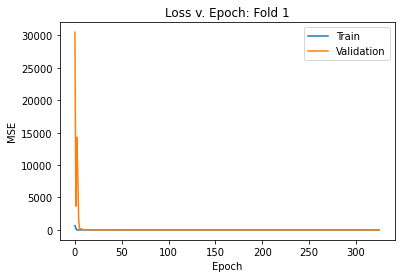

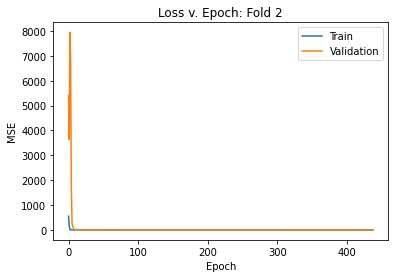

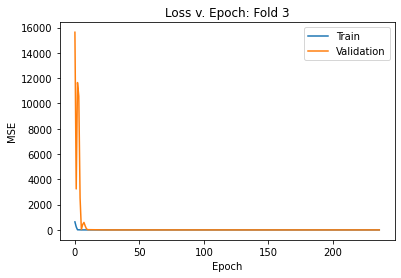

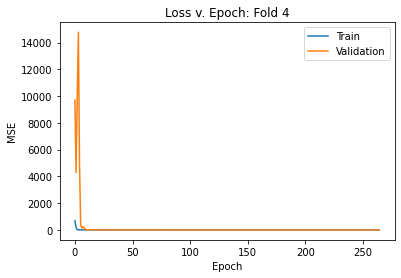

In [7]:
np.random.seed(20)
run_bayesian(bcf_mordred_full_manual_polar, default_domain, max_iter=40, tag='mfmp')

Processing...


2022-10-18 20:29:45.659340: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 20:29:48.532648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38184 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-10-18 20:29:54.155955: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Begin Optimizing...
Optimization Completed.


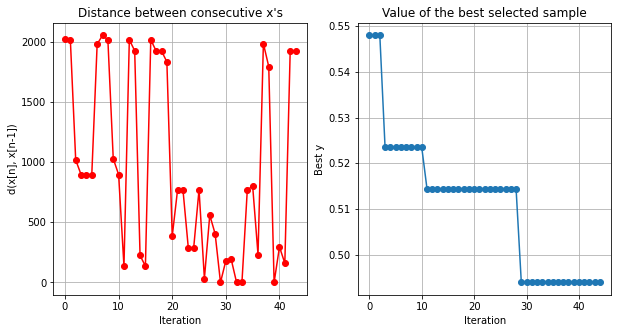

--------------------
Best Hyperparameters:
[('learning_rate', 0.004907030383610637), ('n_layers', 7.0), ('layer_size', 128.0), ('batch_size', 128.0)]
--------------------
Best model print out for Bayesian Optimized Base DNN Model, classy5:
--------------------------
Best MSE Score: 0.49390021547714313
Mean r2: 0.7483529019635486
Mean mae: 0.5076106812721314
Mean rmse: 0.6998490252296129


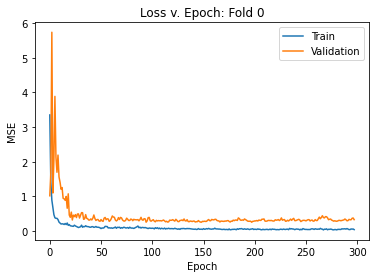

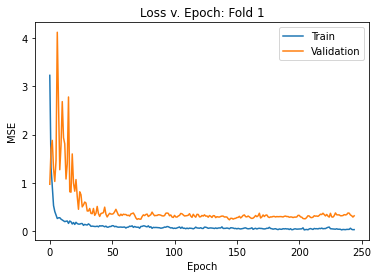

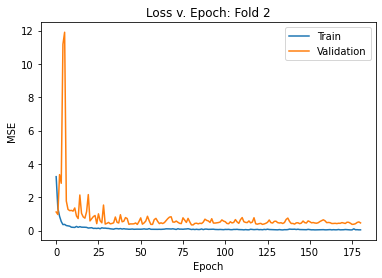

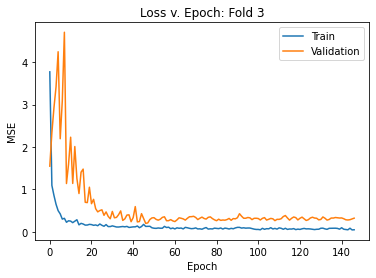

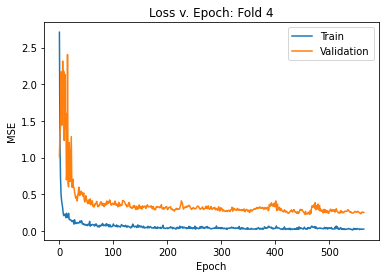

In [6]:
np.random.seed(20)
run_bayesian(bcf_mordred_full_classy_5, default_domain, max_iter=40, tag='classy5')